In [1]:
from jax import random, jit, vmap
import os
import sys
path = os.getcwd()
print("Old path:", path)
path = (path.split('/'))
path = path[:path.index("ABC-SBI")+1]
path = '/'.join(path)
print("New path:", path)
os.chdir(path)
sys.path.append(path)
print(sys.path)
from functions.SBC import logratio_z, logratio_batch_z, post_pdf_z, find_grid_explorative
# from functions.simulation import get_dataset, ABC_epsilon, get_epsilon_star
from functions.training import train_loop
from functions.SBC import SBC_epsilon, plot_SBC, find_grid_explorative, post_pdf_z, post_sample, new_post_pdf_z
import jax.numpy as jnp
import time
import pickle 
import lzma
from jax.scipy.stats import norm, gaussian_kde
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats
from sbibm.metrics import c2st
import torch
import os

Old path: /Users/antoineluciano/Documents/Recherche/ABC-SBI/examples/Gauss-Gauss/Gauss_Gauss_1D_known_sigma
New path: /Users/antoineluciano/Documents/Recherche/ABC-SBI
['/Users/antoineluciano/.pyenv/versions/3.10.13/lib/python310.zip', '/Users/antoineluciano/.pyenv/versions/3.10.13/lib/python3.10', '/Users/antoineluciano/.pyenv/versions/3.10.13/lib/python3.10/lib-dynload', '', '/Users/antoineluciano/.pyenv/versions/3.10.13/envs/jax_env/lib/python3.10/site-packages', '/Users/antoineluciano/Documents/Recherche/ABC-SBI']


/Users/antoineluciano/.pyenv/versions/3.10.13/envs/jax_env/lib/python3.10/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [27]:
data["C2ST_ACCURACY"][1]

{1.0: 1.0, 0.99: 1.0, 0.9: 1.0, 0.5: 1.0, 0.1: 1.0, 0.01: 1.0, 0.001: 1.0}

In [44]:
N_DATA = 10
SIGMA = 1.
SIGMAS0 = [20]
ALPHAS = [1., .99, .9,  .5, .1, .01, .001]

path_ndata = os.getcwd() + "/examples/Gauss-Gauss/Gauss_Gauss_1D_known_sigma/results/local/N_data_{}/".format(N_DATA)


for SIGMA0 in SIGMAS0:
    SIGMA0 = int(SIGMA0)
    file_sigma0 = path_ndata + "GaussGauss_ndata_{}_sigma0_{}.xz".format(N_DATA, SIGMA0)
    with lzma.open(file_sigma0, "rb") as f:
        data = pickle.load(f)
    print("Data loaded:", file_sigma0)
    N_MU = len(data["TRUE_MUS"])
    C2ST_values = np.array([[data["C2ST_ACCURACY"][i][alpha] for i in range(1,N_MU+1)] for alpha in list(data["C2ST_ACCURACY"][1].keys())])
    EPSILONS = np.array([[data["EPSILONS"][i][alpha] for i in range(1,N_MU+1)] for alpha in list(data["EPSILONS"][1].keys())])
    TRUE_MUS = data["TRUE_MUS"]

Data loaded: /Users/antoineluciano/Documents/Recherche/ABC-SBI/examples/Gauss-Gauss/Gauss_Gauss_1D_known_sigma/results/local/N_data_10/GaussGauss_ndata_10_sigma0_20.xz


In [20]:
print("SHapes:", EPSILONS.shape, C2ST_values.shape)

SHapes: (7, 10) (7, 10)


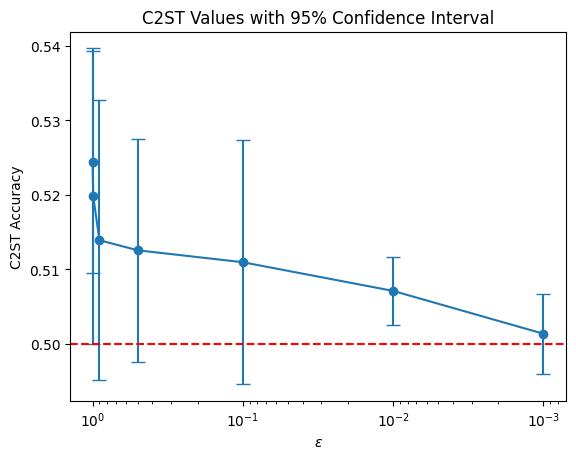

In [55]:
mean_C2ST = np.median(C2ST_values[:,:-1], axis=1)
std_C2ST = np.std(C2ST_values[:,:-1], axis=1)
conf_interval = 1.96 * std_C2ST / np.sqrt(N_MU)
plt.errorbar(ALPHAS, mean_C2ST, yerr=conf_interval, fmt='o-', capsize=5, label=f'SIGMA0={SIGMA0}')
plt.xscale('log')
plt.gca().invert_xaxis()
plt.xlabel('$\epsilon$')
plt.ylabel('C2ST Accuracy')
plt.title('C2ST Values with 95% Confidence Interval')
# plt.legend()
plt.axhline(y=0.5, color='r', linestyle='--', label='Threshold')

plt.show()

In [17]:
EPSILONS = np.array(EPSILONS)
EPSILONS.shape

(7, 10)

In [24]:
np.array(ALPHAS).shape

(7,)

In [25]:
C2ST_values.T.shape

(10, 7)

0


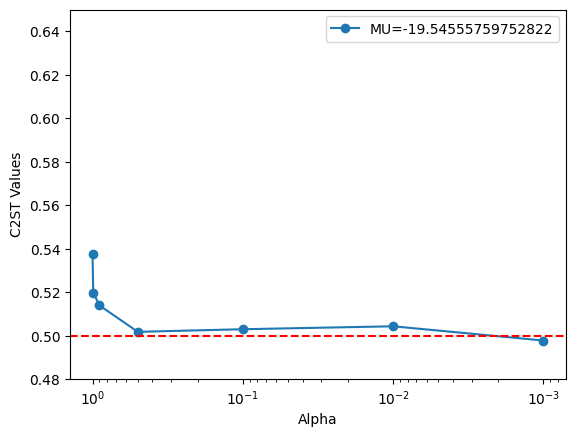

1


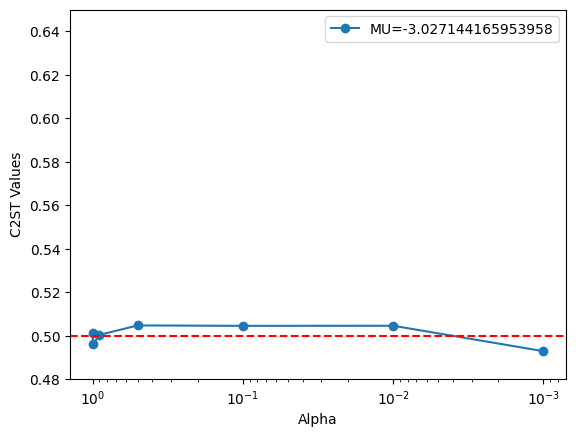

2


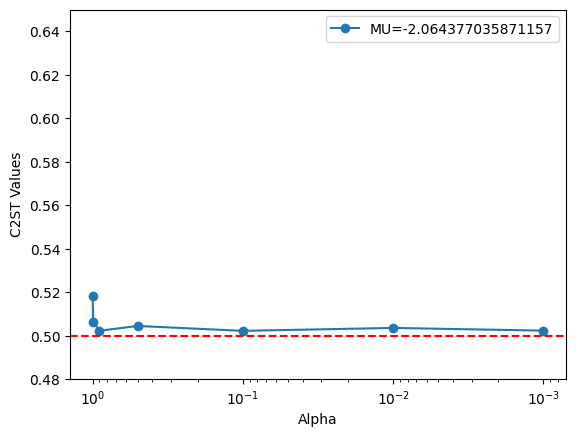

3


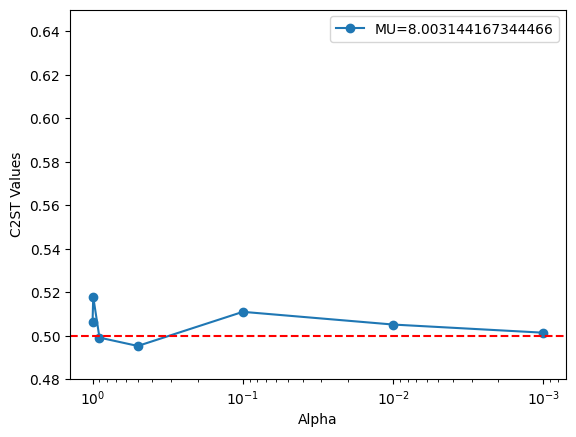

4


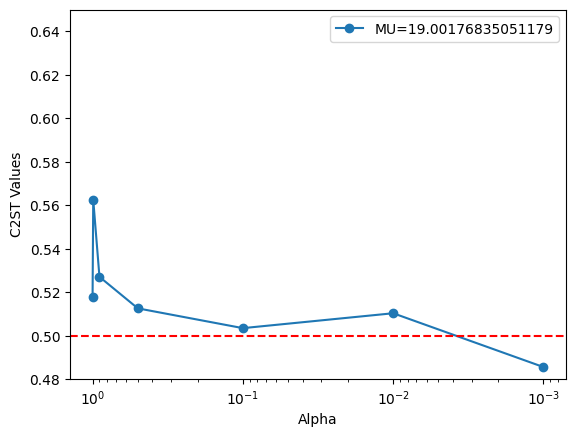

5


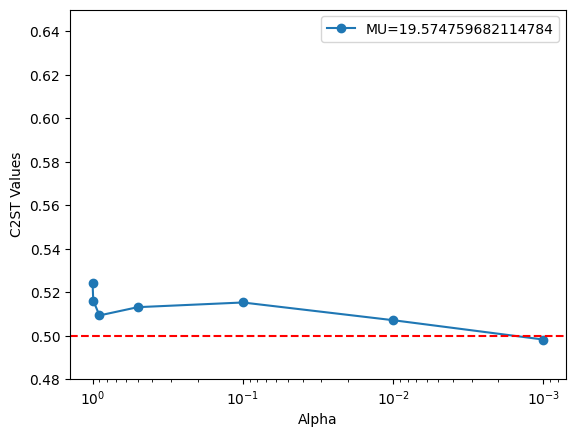

6


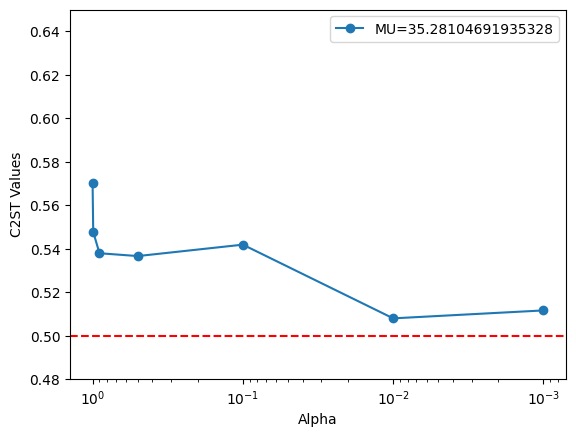

7


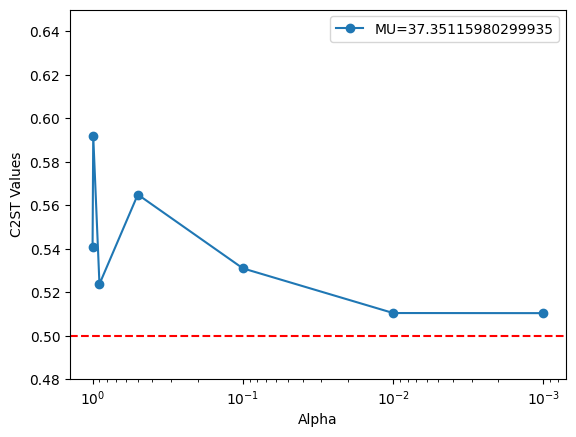

8


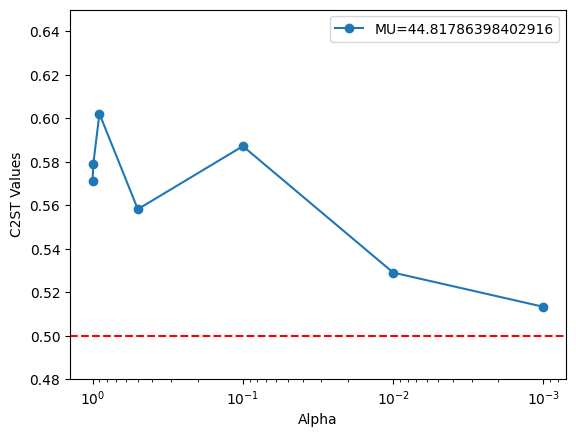

9


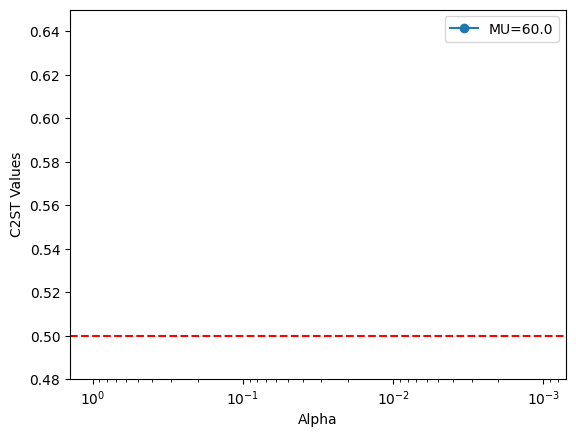

In [46]:
for i in range(len(EPSILONS.T)):
    print(i)
    plt.plot(ALPHAS, C2ST_values.T[i], 'o-', label=f'MU={TRUE_MUS[i]}')
    
# plt.errorbar(ALPHAS, mean_C2ST, yerr=conf_interval, fmt='o-', capsize=5, label=f'SIGMA0={SIGMA0}')
    plt.xscale('log')
    plt.gca().invert_xaxis()
    plt.xlabel('Alpha')
    plt.ylabel('C2ST Values')
    plt.legend()
    plt.axhline(0.5, color='red', linestyle='--')
    plt.ylim(.48, .65)
    plt.show()


In [22]:
C2ST_values = np.array(C2ST_values)
C2ST_values

array([], shape=(7, 0), dtype=float64)

In [24]:
data["C2ST_ACCURACY"][1].keys()


dict_keys([1.0, 0.99, 0.9, 0.5, 0.1, 0.01, 0.001])